In [12]:
import torch
from torchvision import transforms

import torchvision.datasets as datasets
# Using CIFAR-10 dataset
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

from torchvision import models

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange

from tqdm.notebook import tqdm, trange
import os
from torchvision.datasets import ImageFolder
import tarfile

# Define the transformations
transform = transforms.Compose([
    transforms.Resize(160),               # resize to 160×160 for imagenette2-160
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
])
# Paths for the Imagenette dataset (assumes you want it under ./data/imagenette2-160/)
imagenette_root = "./data/imagenette2-160"
train_dir = os.path.join(imagenette_root, "train")
val_dir   = os.path.join(imagenette_root, "val")

# download & extract if not already present
if not os.path.isdir(imagenette_root):
    os.makedirs(os.path.dirname(imagenette_root), exist_ok=True)
    url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
    archive_path = os.path.join(os.path.dirname(imagenette_root), "imagenette2-160.tgz")
    if not os.path.exists(archive_path):
        print("Downloading Imagenette dataset...")
        import urllib.request
        urllib.request.urlretrieve(url, archive_path)
    print("Extracting Imagenette dataset...")
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path=os.path.dirname(imagenette_root))
    print("Done.")

# Load the Imagenette dataset
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset  = ImageFolder(val_dir,   transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=512, shuffle=False)

In [28]:
resnet_pretrained = models.resnet50(pretrained=True)
resnet_pretrained.fc = torch.nn.Identity()

resnet_pretrained_frozen = models.resnet50(pretrained=True)
resnet_pretrained_frozen.fc = torch.nn.Identity()

#load prior tasks
labels_list = np.load('labels_list_imagenette_1.npy')

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# ── 1. Build a “multi-label” view of the data ──────────────────────────────────
labels_matrix = np.stack(labels_list)          # (100, N)
labels_matrix = torch.from_numpy(labels_matrix).float()  # to tensor

class MultiTaskWrapper(torch.utils.data.Dataset):
    def __init__(self, base_ds, all_labels):
        self.base_ds   = base_ds               # the dataset behind your test_loader
        self.all_lbls  = all_labels            # (100, N)
    def __len__(self): return len(self.base_ds)
    def __getitem__(self, idx):
        img, _    = self.base_ds[idx]
        lbl_vec   = self.all_lbls[:, idx]      # (100,)
        return img, lbl_vec

multi_ds     = MultiTaskWrapper(test_loader.dataset, labels_matrix)
multi_loader = torch.utils.data.DataLoader(multi_ds,
                                           batch_size=test_loader.batch_size,
                                           shuffle=False,
                                           num_workers=test_loader.num_workers,
                                           pin_memory=True)

# ── 2. Multi-task linear probe ─────────────────────────────────────────────────
def linear_probe_multi(model, loader, feat_dim = 2048, n_epoch=1):
    n_tasks = 256
    model.eval().cuda()

    head = torch.nn.Linear(feat_dim, n_tasks).cuda()
    crit = torch.nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(head.parameters(), lr=1e-2)
    
    # Add cosine annealing scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt,
        T_max=n_epoch,  # Total number of epochs
        eta_min=1e-6    # Minimum learning rate
    )

    for epoch in trange(n_epoch):
        runloss = 0.
        for imgs, lbls in loader:                  # lbls → (B, 100)
            imgs = torch.nn.functional.interpolate(
                imgs, size=(224,224), mode='bilinear', align_corners=False
            ).cuda(non_blocking=True)
            lbls = lbls.cuda(non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():        # mixed precision, optional
                feats = model(imgs)                # (B, 1000)
                logits = head(feats)               # (B, n_tasks)
                loss = crit(logits, lbls)
            loss.backward()
            opt.step()
            runloss += loss.item()

        # Step the scheduler after each epoch
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

    # ─ Evaluation per task ─
    correct = torch.zeros(n_tasks, device='cuda')
    total   = torch.zeros(n_tasks, device='cuda')

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs  = torch.nn.functional.interpolate(
                        imgs, size=(224,224), mode='bilinear', align_corners=False
                    ).cuda(non_blocking=True)
            lbls  = lbls.cuda(non_blocking=True)

            preds   = (head(model(imgs)) > 0).float()
            correct += (preds == lbls).sum(dim=0)
            total   += lbls.size(0)

    acc = (100*correct/total).cpu().numpy()        # shape (100,)
    return acc

# ── 3. Run it ──────────────────────────────────────────────────────────────────
pre_task_accuracies = linear_probe_multi(resnet_pretrained, multi_loader, n_epoch=30)


  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_19703/765765762.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():        # mixed precision, optional


(array([ 2.,  0.,  0.,  0.,  4.,  5.,  4.,  4., 14., 11., 14., 25., 24.,
        27., 39., 25., 24., 17., 13.,  4.]),
 array([75.00637054, 75.61528778, 76.22420502, 76.83312225, 77.44203949,
        78.05095673, 78.65987396, 79.2687912 , 79.87770844, 80.48662567,
        81.09554291, 81.70446014, 82.31337738, 82.92229462, 83.53121185,
        84.14012909, 84.74904633, 85.35796356, 85.9668808 , 86.57579803,
        87.18471527]),
 <BarContainer object of 20 artists>)

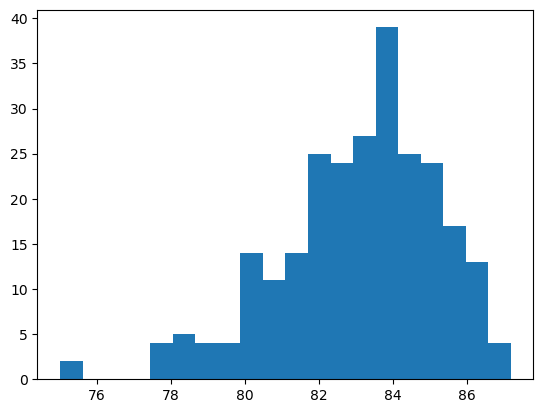

In [4]:
plt.hist(pre_task_accuracies, bins=20)

In [6]:
pre_task_accuracies

array([83.89809 , 79.05733 , 83.617836, 84.28026 , 82.29299 , 79.92357 ,
       83.49045 , 84.254776, 85.70701 , 83.28662 , 82.34395 , 77.78344 ,
       81.63057 , 82.57325 , 85.55414 , 83.64331 , 83.617836, 85.605095,
       85.73248 , 81.52866 , 87.184715, 75.41401 , 81.681526, 82.1656  ,
       84.15286 , 84.891716, 82.54777 , 83.84714 , 84.458595, 84.86624 ,
       84.15286 , 86.42038 , 83.92357 , 83.49045 , 83.23567 , 78.21656 ,
       83.00637 , 85.88535 , 82.57325 , 84.611465, 81.63057 , 84.05096 ,
       81.9363  , 80.12739 , 83.592354, 86.0637  , 86.21656 , 83.108284,
       84.178345, 84.20382 , 78.11465 , 82.92994 , 83.33758 , 82.191086,
       85.01911 , 82.62421 , 80.407646, 81.044586, 85.19745 , 81.52866 ,
       77.8344  , 81.73248 , 80.12739 , 85.1465  , 86.11465 , 83.89809 ,
       83.64331 , 85.044586, 85.57962 , 84.28026 , 85.248405, 82.318474,
       82.87898 , 80.382164, 83.36306 , 85.78344 , 80.968155, 85.63057 ,
       83.92357 , 84.15286 , 81.88535 , 85.98726 , 

In [7]:
def compute_expectation_variance(K, M, T=1.0):
    if K.shape != M.shape:
        raise ValueError("K and M must have the same shape.")

    sigma = torch.sigmoid(K / T)              # σ(K_{ij}/T)
    expectation = (M * sigma).sum()           # Σ M σ
    variance = ((M**2) * sigma * (1 - sigma)).sum()  # Σ M² σ(1−σ)

    return expectation, variance  

In [29]:
beta = 1
T = 1

n_epoch = 30

resnet_pretrained.train()
resnet_pretrained_frozen.eval()

# Initial learning rate
initial_lr = 0.001
optimizer = torch.optim.Adam(resnet_pretrained.parameters(), lr=initial_lr)
# Add cosine annealing scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epoch)

resnet_pretrained.cuda()
resnet_pretrained_frozen.cuda()

for epoch in range(n_epoch):  
    running_loss = 0.0
    running_exp = 0.0
    running_var = 0.0
    n = 0

    for images, labels in train_loader:
        images = torch.nn.functional.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
        images = images.cuda()

        with torch.no_grad():
            outputs = resnet_pretrained_frozen(images)

            norm_outputs = outputs / outputs.norm(dim=1, keepdim=True)
            K = norm_outputs @ norm_outputs.T
            
        outputs = resnet_pretrained(images)

        norm_outputs = outputs / outputs.norm(dim=1, keepdim=True)
        M = norm_outputs @ norm_outputs.T

        exp, var = compute_expectation_variance(K, M, T)

        loss = beta * var -  exp

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print statistics  

        running_loss += loss.item()
        running_exp += exp.item()
        running_var += var.item()

        n += 1

    # Step the scheduler after each epoch
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    print(f'Epoch {epoch+1}, Loss: {running_loss/n:.4f}, Expectation: {running_exp/n:.4f}, Variance: {running_var/n:.4f}, lr {current_lr:.2e}')

Epoch 1, Loss: 5582.4855, Expectation: 37664.7330, Variance: 5582.4855, lr 9.97e-04
Epoch 2, Loss: 2558.8735, Expectation: 21358.5598, Variance: 2558.8735, lr 9.89e-04
Epoch 3, Loss: 1989.5931, Expectation: 16852.3843, Variance: 1989.5931, lr 9.76e-04
Epoch 4, Loss: 1648.6639, Expectation: 14007.6542, Variance: 1648.6639, lr 9.57e-04
Epoch 5, Loss: 1589.9285, Expectation: 13619.2823, Variance: 1589.9285, lr 9.33e-04
Epoch 6, Loss: 1735.6070, Expectation: 15000.7003, Variance: 1735.6070, lr 9.05e-04
Epoch 7, Loss: 1372.0374, Expectation: 12119.5679, Variance: 1372.0374, lr 8.72e-04


KeyboardInterrupt: 

In [7]:
from datetime import datetime

# Save the fine-tuned ResNet backbone with a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"resnet_pretrained_finetuned_{timestamp}.pth"
torch.save(resnet_pretrained.state_dict(), filename)
print(f"Model state_dict saved to {filename} at {timestamp}")

Model state_dict saved to resnet_pretrained_finetuned_20250507_210810.pth at 20250507_210810


In [30]:
task_accuracies = linear_probe_multi(resnet_pretrained, multi_loader, n_epoch=30)

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_19703/765765762.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():        # mixed precision, optional


In [31]:
variance = np.var(task_accuracies)
old_var = np.var(pre_task_accuracies)
print(f"Variance before: {old_var}")
print(f"Variance after: {variance}")

Variance before: 4.570164680480957
Variance after: 2.9348363876342773


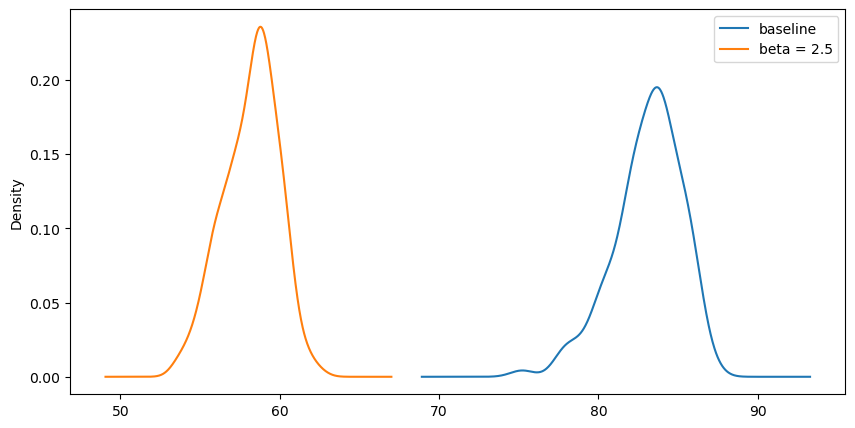

In [32]:
import pandas as pd
plt.figure(figsize=(10, 5))
pd.Series(pre_task_accuracies).plot.kde(label='baseline')
pd.Series(task_accuracies).plot.kde(label='beta = 2.5')

plt.legend()

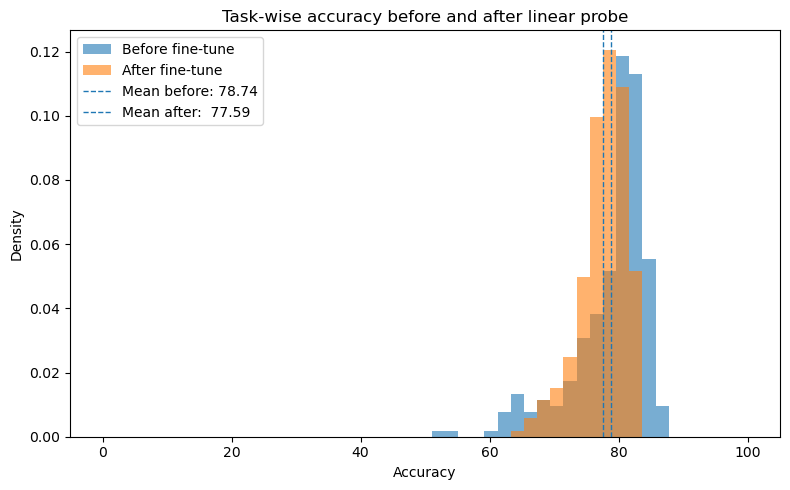

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# ── use identical bin edges so the bars line up ──
bins = np.linspace(0, 100, 50)              # 0 – 1 in 5-point steps

plt.hist(pre_task_accuracies, bins=bins,
         alpha=0.6, density=True,
         label='Before fine-tune')

plt.hist(task_accuracies,     bins=bins,
         alpha=0.6, density=True,
         label='After fine-tune')

# ── mark the means ──
plt.axvline(np.mean(pre_task_accuracies),  linestyle='--', linewidth=1,
            label=f"Mean before: {np.mean(pre_task_accuracies):.2f}")
plt.axvline(np.mean(task_accuracies),      linestyle='--', linewidth=1,
            label=f"Mean after:  {np.mean(task_accuracies):.2f}")

plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Task-wise accuracy before and after linear probe')
plt.legend()
plt.tight_layout()
plt.show()